In [2]:
import os
os.chdir('/lustre/scratch/kiviaho/prostate_spatial')
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt

sns.set_theme(style='white')
from scipy.stats import spearmanr, ttest_ind, mannwhitneyu
import gseapy as gp

from scripts.utils import get_treatment_info, load_from_pickle, get_sample_id_mask

import warnings

import anndata as ad
#from pydeseq2 import dds
#from pydeseq2.ds import DeseqStats
#from pydeseq2.default_inference import DefaultInference

# Filter out all warnings
warnings.filterwarnings("ignore")


treatment_mapping_dict_simple = {
'bph':'BPH',
'untreated':'TRNA',
'goserelin':'NEADT',
'bicalutamide':'NEADT',
'degarelix':'NEADT',
'degarelix_apalutamide':'NEADT',
'crpc':'CRPC'}


masked_sample_ids = get_sample_id_mask()

## Loading and normalizing pseudobulked data

In [3]:
pseudobulk_dat = pd.read_csv('data/spatial_pseudobulk_unnormalized.csv',index_col=0)
treat_info = get_treatment_info()

# Specify the path to your GTF file
gtf_file_path = './gencode.v43.annotation.gtf'

# Since the data has come through different pipelines, some genes might be present in only Tampere or only ARNEO
# Drop the genes that have 0 counts in either cohort
tampere_samples = pseudobulk_dat.columns[:37].tolist()
arneo_samples = pseudobulk_dat.columns[37:].tolist()
pseudobulk_dat = pseudobulk_dat[(pseudobulk_dat[tampere_samples].sum(axis=1) != 0) & (pseudobulk_dat[arneo_samples].sum(axis=1) != 0)]


### TPM normalization

In [5]:
def extract_gene_lengths_from_gtf(file_path):
    gene_lengths = {}

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            data = line.strip().split('\t')
            if data[2] == 'gene':
                attributes = data[8].split(';')
                gene_name = [x.split('"')[1] for x in attributes if 'gene_name' in x][0]
                start = int(data[3])
                end = int(data[4])
                length = end - start + 1
                gene_lengths[gene_name] = length

    return gene_lengths


In [6]:
# Extract gene lengths from the GTF file
gene_lengths = extract_gene_lengths_from_gtf(gtf_file_path)

# Subset the pseudobulk data to only contain those genes that have annotation
pseudobulk_dat = pseudobulk_dat[pseudobulk_dat.index.isin(gene_lengths.keys())]

# Map the gene lengts to pseudobulk genes 
gene_length_mapping = pseudobulk_dat.index.map(gene_lengths).tolist()

# Transform gene lenghts to kilobase
gene_length_mapping = np.array(gene_length_mapping,dtype=float)/1e3

# Function to calculate TPM
def calculate_tpm(df,gene_lengths_per_kb=gene_length_mapping):

    # Gene reads per kilobase
    df_rpk = df.divide(gene_lengths_per_kb,axis=0)

    # Total rpk per sample 
    sample_scaling_factor = df_rpk.sum()/1e6

    # TPM
    tpm_df = df_rpk.divide(sample_scaling_factor)

    return tpm_df


In [7]:

# Perform TPM normalization
tpm_normalized_dat = calculate_tpm(pseudobulk_dat)

# Modify the counts and subet categories

categories =['untreated','goserelin','bicalutamide', 'degarelix','degarelix_apalutamide']

# Add pseudocount and log2-transform
log2_tpm_normalized_dat = np.log2(tpm_normalized_dat.T +1 )

# Map treatment and filter according TRNA-NEADT
log2_tpm_normalized_dat['treatment'] = log2_tpm_normalized_dat.index.map(treat_info).map(treatment_mapping_dict_simple).tolist()
log2_tpm_normalized_dat['treatment_detailed'] = log2_tpm_normalized_dat.index.map(treat_info)


### Differential expression testing on TPM-normalized pseudobulk data with pyDESeq2

In [8]:
# Transpose the data
pseudobulk_dat_T = pseudobulk_dat.T

# Add the treatment information
pseudobulk_dat_T['treatment'] = pseudobulk_dat_T.index.map(treat_info).map(treatment_mapping_dict_simple).tolist()

# Filter to contain only the treatnment-naive and the ADT treated
pseudobulk_dat_T =  pseudobulk_dat_T[pseudobulk_dat_T['treatment'].isin(['TRNA','NEADT'])]


In [ ]:
# Construct the DESeq2 dataset
pseudobulk_as_adata = ad.AnnData(pseudobulk_dat_T.drop(columns=['treatment']),
           var=pd.DataFrame(index=pseudobulk_dat_T.drop(columns=['treatment']).columns),
           obs=pseudobulk_dat_T[['treatment']]
           )

deseq_dataset = dds.DeseqDataSet(adata=pseudobulk_as_adata,design_factors='treatment', ref_level=['treatment','TRNA'])

# Run the DESeq2 analysis
deseq_dataset.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 14.55 seconds.

Fitting dispersion trend curve...
... done in 1.29 seconds.

Fitting MAP dispersions...
... done in 14.90 seconds.

Fitting LFCs...
... done in 2.35 seconds.

Refitting 972 outliers.

Fitting dispersions...
... done in 0.53 seconds.

Fitting MAP dispersions...
... done in 0.55 seconds.

Fitting LFCs...
... done in 0.23 seconds.



In [ ]:
# Define the inference
inference = DefaultInference(n_cpus=2)

# Calculate the test statistics, lfc and p-values
stat_res = DeseqStats(deseq_dataset, inference=inference)
stat_res.summary()

# Get the final dataframe
de_res = stat_res.results_df.copy()

# Save the results into a csv file for later use
de_res.to_csv('./data/pseudobulk_deseq_res_trna_vs_neadt.csv')

Running Wald tests...
... done in 6.79 seconds.



Log2 fold change & Wald test p-value: treatment NEADT vs TRNA
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        421.275726        0.767528  0.327602  2.342865  0.019136  0.058806
A1BG-AS1     53.164989        0.829052  0.319680  2.593381  0.009504  0.034466
A1CF          0.285621        0.893868  3.081769  0.290050  0.771778       NaN
A2M       15241.339844        0.436836  0.300557  1.453419  0.146107  0.274791
A2M-AS1      51.585648        0.677634  0.198633  3.411488  0.000646  0.004178
...                ...             ...       ...       ...       ...       ...
ZXDC        308.620392        0.348826  0.150626  2.315842  0.020567  0.062229
ZYG11A       49.847469        0.226922  0.358821  0.632409  0.527120  0.672008
ZYG11B      546.892944       -0.125416  0.105577 -1.187906  0.234871  0.386940
ZYX        2827.512939        0.452416  0.208853  2.166195  0.030296  0.083276
ZZEF1       434.725708        0.108729  0.075083  1.448114  0.147585 

In [ ]:
# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/pseudobulk_deseq2_results_trna_vs_neadt.xlsx', engine='xlsxwriter')

# Write the dataframe into a  Excel file
de_res.reset_index(names='gene').to_excel(writer)

# Save and close the Excel writer
writer.save()

## Plot the expression of relevant DE genes

### Download the DESeq2 results from a file

In [9]:
de_res = pd.read_csv('./data/pseudobulk_deseq_res_trna_vs_neadt.csv',index_col=0)
de_res = de_res.sort_values('log2FoldChange')
de_res_signif = de_res[(np.abs(de_res['log2FoldChange']) >=1) & (de_res['padj'] < 0.05)].sort_values('log2FoldChange') 
de_res_signif

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ORM2,205.163010,-5.892494,1.221084,-4.825625,0.000001,0.000030
PCGEM1,282.375000,-4.911999,1.130320,-4.345672,0.000014,0.000199
FGL1,18.941490,-4.875488,1.253155,-3.890570,0.000100,0.000969
ORM1,63.875935,-4.637892,1.575119,-2.944471,0.003235,0.014901
LLCFC1,1.912150,-4.634777,1.337713,-3.464703,0.000531,0.003549
...,...,...,...,...,...,...
CCN1,1389.128500,19.841198,6.789952,2.922141,0.003476,0.015720
CCN2,2127.088900,20.177806,6.508118,3.100406,0.001933,0.010008
IGLC1,2901.869000,20.290042,5.781115,3.509711,0.000449,0.003112
TLE5,3082.846000,20.573904,6.095636,3.375186,0.000738,0.004648


### Look for relevant genes

In [10]:
# Download the gene lists
gene_set_df = pd.read_excel('custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T

# Fix some of the encoding
gene_set_df = gene_set_df.replace({'NKX3–1':'NKX3-1','C1ORF116':'C1orf116'})

def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_240229.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df

marker_genes = check_top_markers('Club epithelium')['gene'].tolist()

In [11]:
#gene_set = gene_set_df['AR signaling'].tolist()
#gene_set = gene_set_df['SASP upregulated'].tolist()
gene_set = gene_set_df['MP19 Epithelial Senescence'].tolist()

# Find which genes that 1) belong to a signature (and are Club region-specific markers) 
# 2) are differentially expressed between NEADT & TRNA

# Optional intersect with club region marker genes
gene_set = np.intersect1d(marker_genes,gene_set)

for g in de_res_signif.index.tolist():
    if g in gene_set:
        print(de_res_signif.loc[g,['baseMean','log2FoldChange','padj']])
        print('')

baseMean          1362.059300
log2FoldChange       1.224156
padj                 0.033418
Name: KRT7, dtype: float64

baseMean          2206.22300
log2FoldChange       1.29904
padj                 0.00006
Name: IGFBP3, dtype: float64

baseMean          535.675100
log2FoldChange      1.499834
padj                0.000161
Name: CRABP2, dtype: float64

baseMean          1145.236700
log2FoldChange       2.018718
padj                 0.000018
Name: SLPI, dtype: float64

baseMean          533.733950
log2FoldChange      2.508518
padj                0.027750
Name: KRT13, dtype: float64



### Plotting an expression heatmap (Figures 5f) 

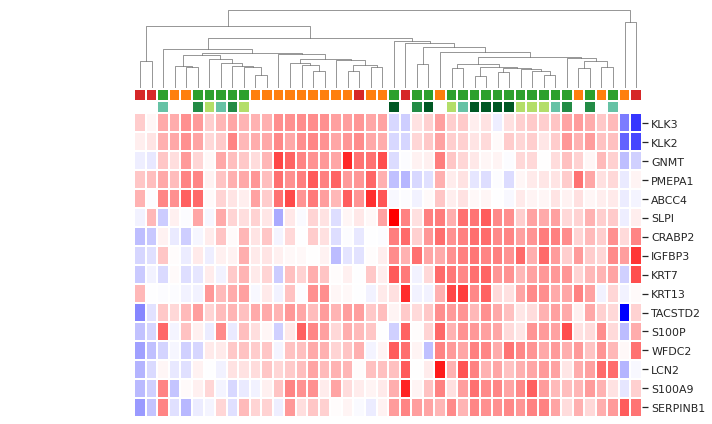

In [12]:
# Heatmap: include genes with relevance in terms of relevance to club-like senescence
genes = [
    'KLK3','KLK2','GNMT','PMEPA1','ABCC4', # AR
    'SLPI','CRABP2','IGFBP3','KRT7','KRT13',# EpiSen/club-region markers
    'TACSTD2','S100P','WFDC2','LCN2','S100A9','SERPINB1',
    ]
    
plot_df = log2_tpm_normalized_dat[log2_tpm_normalized_dat['treatment'].isin(['TRNA','NEADT','CRPC'])].copy()
plot_df = plot_df[genes+['treatment','treatment_detailed']]

col_colors1 = plot_df['treatment'].map({'TRNA':'#ff7f0e','NEADT':'#2ca02c','CRPC':'#d62728'})
col_colors2 = plot_df['treatment_detailed'].map({
    'untreated': '#FFFFFF',
    'crpc': '#FFFFFF',
    'bicalutamide': '#b3de69',  # Light green
    'goserelin': '#66c2a5',  # Medium green
    'degarelix': '#238b45',  # Dark green
    'degarelix_apalutamide': '#005824'  # Darkest green
}

)

h = sns.clustermap(
    plot_df.drop(columns=['treatment','treatment_detailed']).T,
               z_score=0,
               cmap='bwr',
               col_colors=[col_colors1,col_colors2],
               col_cluster=True,
               row_cluster=False,
               linewidth=0.2,
               figsize=(10,6),
               xticklabels='',
               cbar_pos=None,
               )

plt.savefig('plots/pseudobulk_log2TPM_heatmap_AR_EpiSen.pdf')

plot_df = h.data2d.copy()
plot_df.columns = plot_df.columns.map(masked_sample_ids)
plot_df.to_excel('./source_data/figure_5f.xlsx')

### Plotting an expression violinplot with DEG asterisks (Figure 5i)

In [31]:
# Violinplot

plot_df = log2_tpm_normalized_dat[log2_tpm_normalized_dat['treatment'].isin(['TRNA','NEADT'])].copy()
sns.set_theme(style='whitegrid')
sns.set_palette(sns.color_palette(['#ff7f0e','#2ca02c']))

# Add dividers
plot_df[''] = np.nan
plot_df[' '] = np.nan
plot_df['  '] = np.nan

genes = [
    'KLK3','KLK2','GNMT','PMEPA1','ABCC4','', # AR-signaling genes
    'KRT7','KRT13','CRABP2','IGFBP3','SLPI','  ', # EpiSen markers
    'CEBPB','CD68','CXCL1','CXCL2','CXCL8','PLAUR','NFKB1','IL1RN' # NLR-associated
    ]

plot_df = plot_df[genes + ['treatment']].reset_index().melt(['index','treatment'])
plot_df = plot_df.rename(columns={'index':'sample'})
plot_df['sample'] = plot_df['sample'].map(masked_sample_ids)


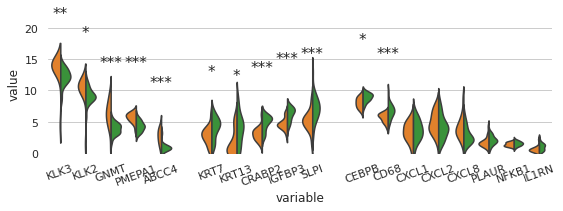

In [30]:

fig, ax = plt.subplots(figsize=(8,3))
sns.violinplot(plot_df,x='variable',y='value',hue='treatment',split=True,inner=None)

ax.set_ylim(0,plot_df['value'].max() + plot_df['value'].max()/2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_legend().remove()
plt.tight_layout()

# Set significance markers and place them at the correct location

marker_lst = []
for g in genes:

    try: 
        padj = de_res.loc[g,'padj']
        if padj < 0.001:
            marker_lst.append('***')
        elif padj < 0.01:
            marker_lst.append('**')
        elif padj < 0.05:
            marker_lst.append('*')
        else:
            marker_lst.append('')
    except:
        marker_lst.append('')

for i,g in enumerate(genes):
    vals = plot_df[plot_df['variable']==g]['value']
    ymax = plot_df['value'].max() +2 - (8-vals.mean()) # Place the asterisks approximately on top of the violin
    ax.text(x=i,y=ymax,s=marker_lst[i],ha='center',fontdict={'size':15})

#plt.savefig('plots/pseudobulk_violin_AR_senescence_NLR.pdf')
plt.show()

# Save plot source data
plot_df.to_excel('./source_data/figure_5i.xlsx')

### Plot score correlations without overlap (Supplementary figures)

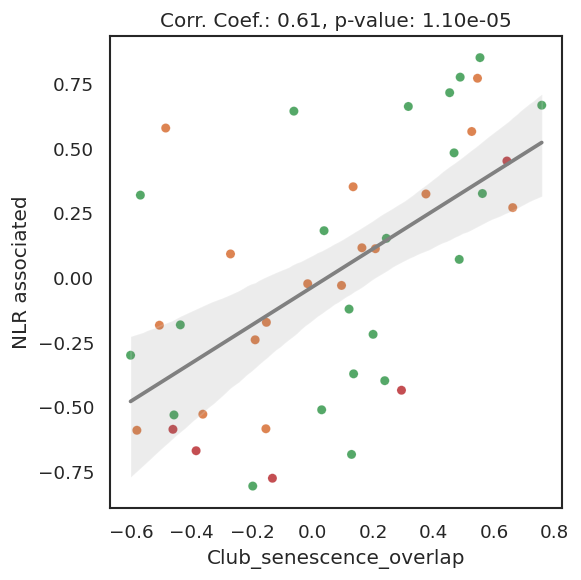

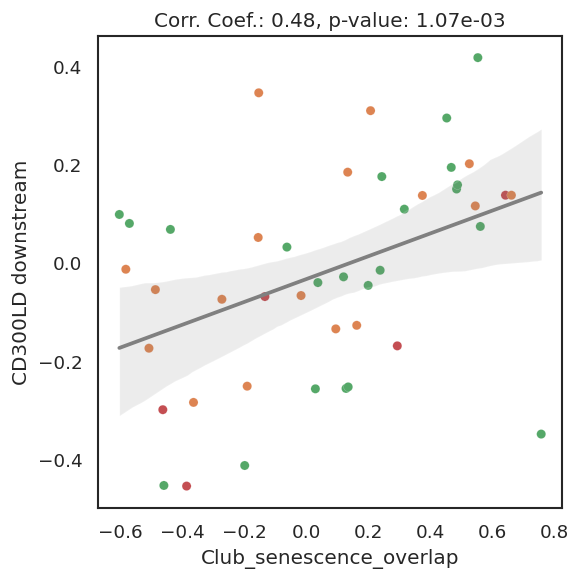

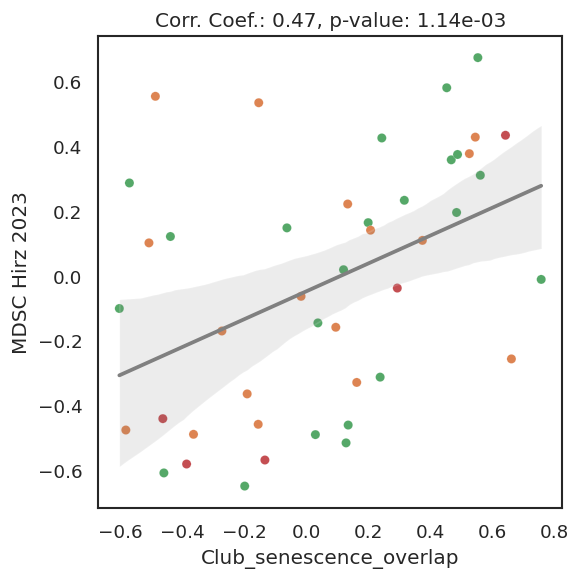

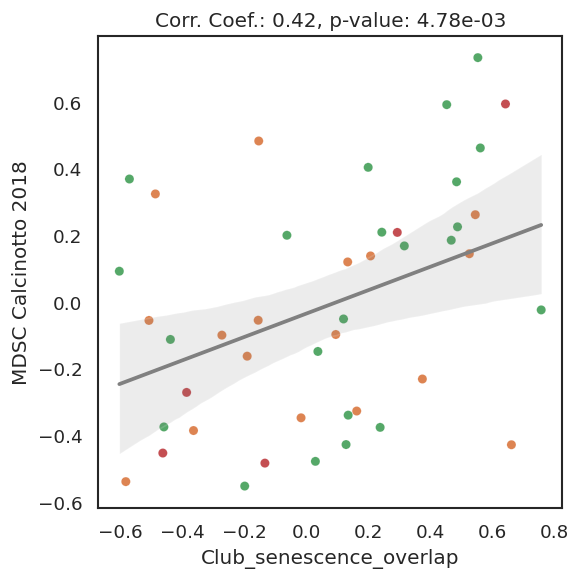

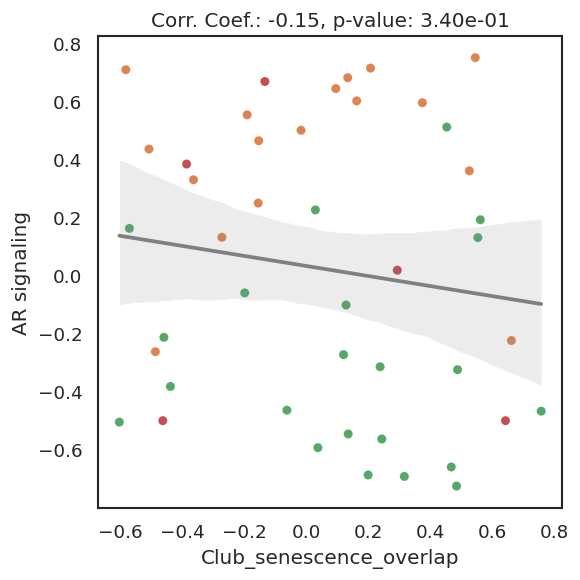

In [43]:
sns.set_theme(style='white')
# Signature-specific scoring is required, as overlaps need to be taken into account

signature1 = 'club_like_senescence'#'Club region'#'MP19 Epithelial Senescence'
signature2s = ['High NLR-associated','CD300LD downstream','MDSC Hirz 2023','MDSC Calcinotto 2018','AR signaling']


simple_gene_modules_dict = {
    signature1: gene_modules_dict[signature1]
}

for signature2 in signature2s:
    simple_gene_modules_dict[signature2] = set(gene_modules_dict[signature2]).difference(gene_modules_dict[signature1]) # Only remove the overlap from one gene set

pseudobulk_dat_log2_tpm = log2_tpm_normalized_dat.drop(columns=['treatment','treatment_detailed']).T

gsva_res = gp.gsva(data=pseudobulk_dat_log2_tpm,gene_sets=simple_gene_modules_dict,outdir=None,min_size=0)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

# Add a sample class identifier column
gsva_res_df['sample_class'] = gsva_res_df['Sample Identifier'].map(treat_info).map(treatment_mapping_dict_simple).astype('category').cat.set_categories(['BPH','TRNA','NEADT','CRPC'])

gsva_res_df[signature1] = gsva_res_df[signature1].astype(float)

gsva_res_df = gsva_res_df[gsva_res_df['sample_class'].isin(['TRNA','NEADT','CRPC'])] # 'BPH','TRNA','NEADT','CRPC'

for signature2 in signature2s:

    gsva_res_df[signature2] = gsva_res_df[signature2].astype(float)

    ## PLOT ##
    fig, ax = plt.subplots(figsize=(5,5),dpi=120)
    # create scatterplot with color-coded points
    sns.scatterplot(x=signature1, y=signature2, data=gsva_res_df, hue='sample_class', linewidth=0.1, s=30, ax=ax,legend=False) # 

    # add regression line to plot
    sns.regplot(x=signature1, y=signature2, data=gsva_res_df, scatter=False, ax=ax,color='gray')

    #ax.set_ylim(-0.5,1.0)
    #ax.set_xlim(0,1.2)
    corr_coef, p_value = spearmanr(gsva_res_df[signature1], gsva_res_df[signature2])


    ax.set_title(f"Corr. Coef.: {corr_coef:.2f}, p-value: {p_value:.2e}")
    plt.tight_layout()

    #plt.savefig('plots/score_correlations/'+signature1.replace(' ','_')+'_'+signature2.replace(' ','_')+'_signature_correlation_in_bulk_no_overlap.pdf')

    plt.show()
    #plt.clf()